## **Sequences**

* We have data in order (time)
* We want to take advantage of the information over time.
* Sequences have enumerated data points (order).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
## - suppose you have inventory data
np.random.seed(630)
t = np.arange(0, 1000)  ## order
x = np.sin(0.02*t) + 2*np.random.rand(1000)  ## inventory
df = pd.DataFrame(x, columns = ['inventory'])
df.head()

,inventory
0,0.107203
1,1.002184
2,1.289523
3,0.470622
4,1.903999


Text(0, 0.5, 'inventory')

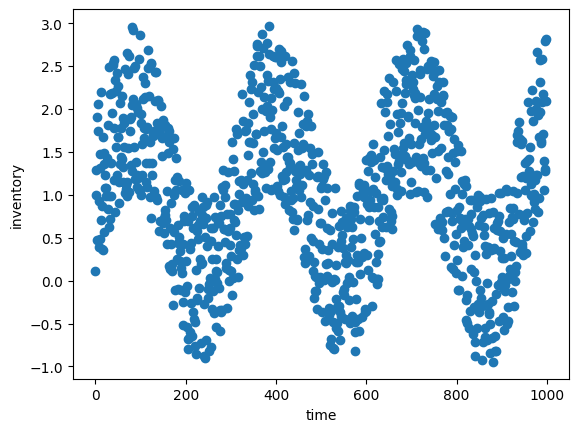

In [7]:
plt.scatter(t, df)
plt.xlabel('time')
plt.ylabel('inventory')

In [10]:
## what if we wanted use XGBoost
## X and y
df['inventory'].shift(2)

,inventory
0,NaN
1,NaN
2,0.107203
3,1.002184
4,1.289523
...,...
995,1.054817
996,1.397236
997,2.797058
998,1.278691


In [12]:
## create lagged values and use as predictors
df_features = pd.concat([df.shift(4), df.shift(3), df.shift(2), df.shift(1), df], axis = 1)
df_features.columns = ['t-4', 't-3', 't-2', 't-1', 't']
df_features.head()

,t-4,t-3,t-2,t-1,t
0,NaN,NaN,NaN,NaN,0.107203
1,NaN,NaN,NaN,0.107203,1.002184
2,NaN,NaN,0.107203,1.002184,1.289523
3,NaN,0.107203,1.002184,1.289523,0.470622
4,0.107203,1.002184,1.289523,0.470622,1.903999


In [13]:
df_features.dropna(inplace = True)
df_features.head()

,t-4,t-3,t-2,t-1,t
4,0.107203,1.002184,1.289523,0.470622,1.903999
5,1.002184,1.289523,0.470622,1.903999,2.056846
6,1.289523,0.470622,1.903999,2.056846,1.742945
7,0.470622,1.903999,2.056846,1.742945,0.395736
8,1.903999,2.056846,1.742945,0.395736,0.932458


In [14]:
## for sequences you need to keep order
## train/test split has to keep order
## train/test should NOT be random
X_train, X_test = df_features.iloc[0:700, :4], df_features.iloc[700:, :4]
y_train, y_test = df_features.iloc[0:700, 4], df_features.iloc[700:, 4]

In [15]:
from xgboost import XGBRegressor

## instance fit
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [16]:
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)
r2_score(y_test, y_pred)

0.34255427633811986

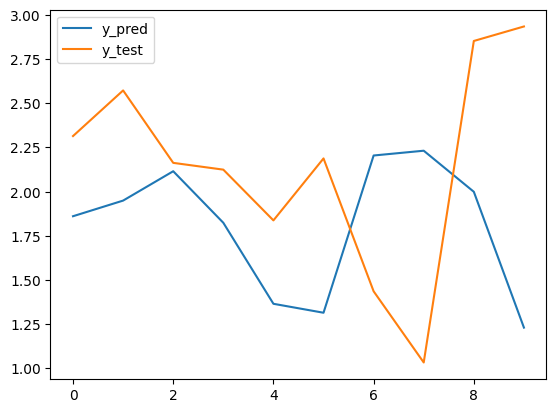

In [19]:
## plot the y_pred and y_test
plt.plot(y_pred[:10], label = 'y_pred')
plt.plot(y_test.values[:10], label = 'y_test')
plt.legend()
plt.show()

In [20]:
### Deep Learning Models - FF
### does not into account the sequence
### should perform as well or better than XGBoost, RF (tree-based)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

model2 = Sequential()
model2.add(Input(shape = (4,)))
model2.add(Dense(16, activation = 'relu'))
model2.add(Dense(8, activation = 'relu'))
model2.add(Dense(1))

model2.compile(optimizer = 'adam', loss = 'mse')
model2.fit(X_train, y_train, epochs = 100, verbose = 0)

In [21]:
r2_score(y_test, model2.predict(X_test))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


0.48421880609104173

#### **Neurons vs Recurrent Neurons (Sequences)**

In [24]:
## Example of regular neuron
def relu(z):
  return np.maximum(0, z)

## weights
w = np.array([0.2, -.3, -.1, .9])  ## weights
b = -1                              ## bias

## neuron sum and activation
x = X_train.iloc[0, :]  ## first obs from X_train
z = x.dot(w) + b
a = relu(z)
print(f'sum is {z} and activation is {a}')

sum is -0.9846071530718127 and activation is 0.0


In [27]:
## Recurrent Neurons works with sequences (takes the whole sequence)
seq1 = df[:4].T
seq1

,0,1,2,3
inventory,0.107203,1.002184,1.289523,0.470622


In [33]:
## weight for input (regular)
Wx = 0.5
## weight for the loop (hidden state)
Wh = 0.8
## bias
b = 1

## start hidden state (usually started at 0)
h = 0

##
for t, x in enumerate(seq1):
  h = relu(Wx*x + Wh*h + b)
  print(f'hidden state at time {t} is {h}')

hidden state at time 0 is 1.0
hidden state at time 1 is 2.3
hidden state at time 2 is 3.84
hidden state at time 3 is 5.572


In [35]:
## Recurrent Neural Network
## Neurons (use simpleRNN as opposed to Dense)
## We dont want to use the whole sequence
## We create small sequences (window size or length)

In [43]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

## train / test
train, test = df.iloc[0:700].values, df.iloc[700:].values  ## numpy arrays

## window size (length)
generator_train = TimeseriesGenerator(train, train, length = 4, batch_size = 1)

generator_test = TimeseriesGenerator(test, test, length = 4, batch_size = 1)

In [46]:
generator_train[1]

(array([[[1.00218441],
         [1.28952292],
         [0.47062206],
         [1.90399864]]]),
 array([[2.05684565]]))

In [ ]:
## RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, SimpleRNN

model3 = Sequential()
model3.add(Input(shape = (4, 1)))
model3.add(SimpleRNN(16, activation = 'relu'))
model3.add(Dense(8, activation = 'relu'))
model3.add(Dense(1))

model3.compile(optimizer = 'adam', loss = 'mse')
model3.fit(generator_train, epochs = 100, verbose = 0, validation_data = generator_test)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [ ]:
r2_score(y_test, model3.predict(X_test))